# Introduction


**What?** Prediction interval with XGBoost and logcosh smooth quantile objective function<br>



# Import modules

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
rcParams['figure.figsize'] = 14, 6
rcParams['font.size'] = 20

# Non-smooth quantile regression objective function


- The go-choice loss function for regression is the MSE (L2). 
- That’s well and good, but this says nothing about how **varied** (<- that is the keyword!) the residuals are.
- There is an alternative found in a different loss function: **quantile**!
- If you set a alpha=95%, this means that 95% of the true observations are below the predicted values as the formula is (true-pred<0)
- If you set alpha to 0.05, only 5% of the observations are below the prediction. 
- Thus, 90% of real values lie between these two predictions. This is 90% is called **confidence level** (not interval!).
- The formula reported below is known as the **non-smooth** quantile formulation.
- There is a singularity in (0, 0), so it is not **C1**. 
- This is an issue, as gradient boosting methods require an objective function of class C2, i.e. that can be differentiated twice.
- Keep in mind thath although it is called gradient boosting, you also need the hessian matrices, thus the second derivative. 



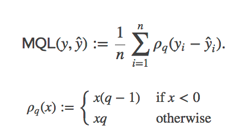

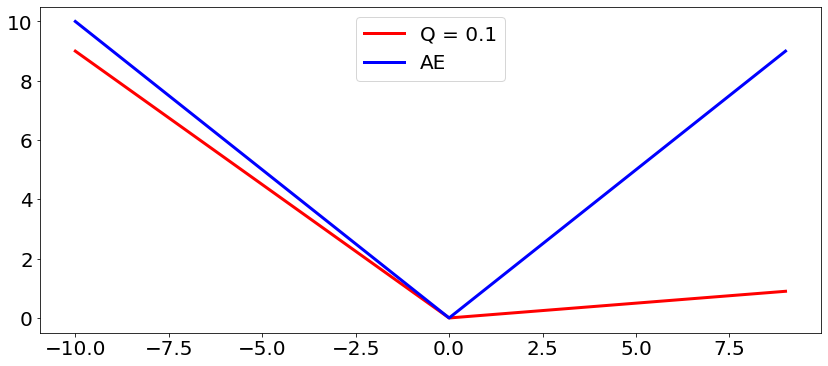

In [2]:
# q is the quantile
# x is a sweep of synthetic errors ranging from negative to positive values
q = 0.1
x = np.array(range(-10, 10))
# where(condition statement, if True, if False)
y = np.where(x > 0, q * x, (q - 1) * x)

yAE = np.where(x >= 0, x, - x)
plt.plot(x, y, "r-", lw = 3, label = f'Q = {q}')
plt.plot(x, yAE, "b-", lw = 3, label = "AE")
plt.legend(loc = 'upper center')
plt.show()

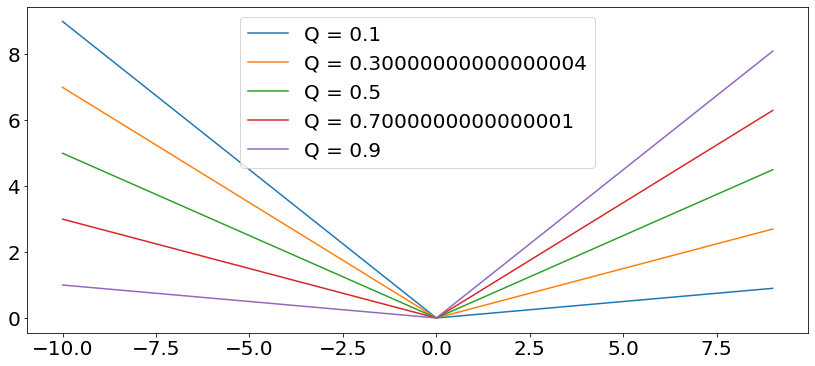

In [3]:
# q is the quantile
# x is a sweep of synthetic errors ranging from negative to positive values
for q in np.linspace(0.1, 0.9, 5):
    x = np.array(range(-10, 10))
    y = np.where(x > 0, q * x, (q - 1) * x)
    plt.plot(x, y, label = f'Q = {q}')
plt.legend(loc = 'upper center')
plt.show()

# Log(cosh(x)) quantile loss function


- Here it is shown a way to make this function smooth meaning C2 differentiable.
- This quantile function is simply the MAE (Mean Absolute Error, formula is reported below), **scaled and rotated**.
- But how do you turn a MAE into something similar to the quantile loss but smooth?
- All we do is to use the **log(cosh(x))** function.
- There is **no extra** hyperparameter to tune. Other models do not offer the same advantage. One of these is reported here: https://towardsdatascience.com/regression-prediction-intervals-with-xgboost-428e0a018b



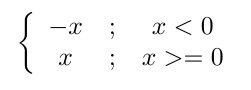

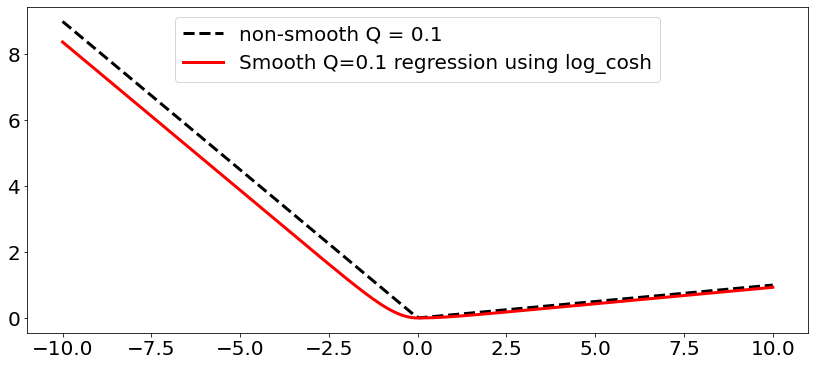

In [4]:
x = np.linspace(-10, 10, 200)
y = np.abs(x)
alpha = 0.1
y_Q = np.where(x > 0, alpha * x, (alpha - 1) * x)

from numpy import e
y_logcosh = np.where(x > 0, alpha * np.log(np.cosh(x)), (1 - alpha) * np.log(np.cosh(x)))
plt.plot(x, y_Q, "k--", lw = 3, label = 'non-smooth Q = ' + str(alpha))
plt.plot(x, y_logcosh, "r-", lw = 3, label = "Smooth Q=" + str(alpha) + " regression using log_cosh")
plt.legend(loc = "upper center")
plt.show()

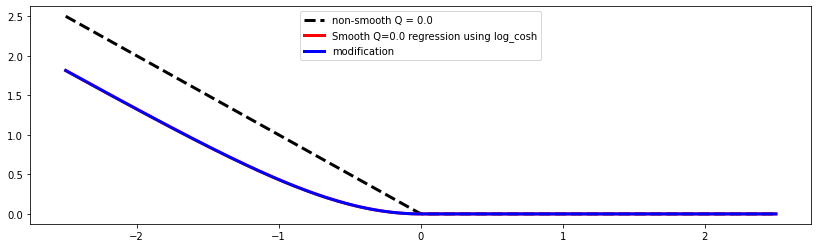

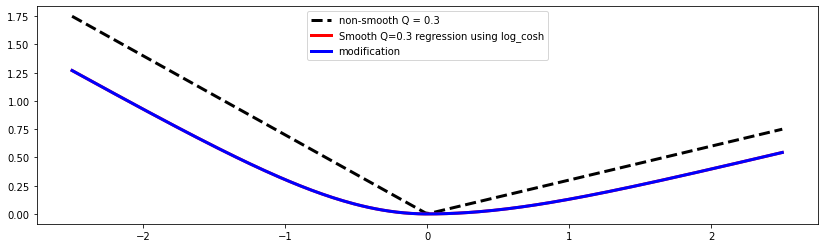

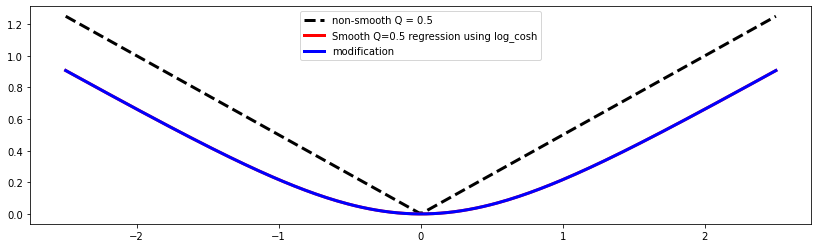

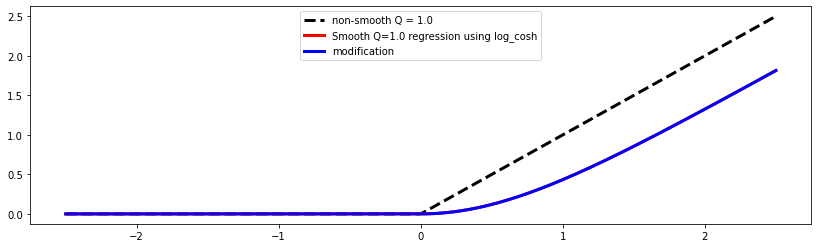

In [5]:
rcParams['figure.figsize'] = 14, 4
rcParams['font.size'] = 10

x = np.linspace(-2.5, 2.5, 200)
y = np.abs(x)
alphas = [0.0, 0.3, 0.5, 1.0]
for alpha in alphas:
    y_Q = np.where(x > 0, alpha * x, (alpha - 1) * x)
    a= 1
    from numpy import e
    y_logcosh = np.where(x > 0, alpha * np.log(np.cosh(x)), (1 - alpha) * np.log(np.cosh(x)))
    
    mod = np.log(np.cosh(x**a))
    y_logcosh_mod = np.where(x > 0, alpha * mod, (1 - alpha) * mod) 

    plt.plot(x, y_Q, "k--", lw = 3, label = 'non-smooth Q = ' + str(alpha))
    plt.plot(x, y_logcosh, "r-", lw = 3, label = "Smooth Q=" + str(alpha) + " regression using log_cosh")
    plt.plot(x, y_logcosh_mod, "b-", lw = 3, label = "modification")
    plt.legend(loc = "upper center")
    plt.show()

# Creating a XGBOOST custom-made loss function


- You do not need to pass the function itself but the gradient and the its hessian.
- Reference: https://stackoverflow.com/questions/59683944/creating-a-custom-objective-function-in-for-xgboost-xgbregressor
- The log(cosh) quantile is a regularised and **SMOOTH** quantile loss function.
- The XGBoost the library passes the predicted values (y_pred) and the ground truth values (y_true) in this order. 



In [6]:
def log_cosh_quantile(alpha):    
    def _log_cosh_quantile(y_true, y_pred):
        err = y_pred - y_true        
        err = np.where(err < 0, alpha * err, (1 - alpha) * err)
        
        grad = np.tanh(err)          
        hess = 1 / np.cosh(err)**2
            
        return grad, hess
    return _log_cosh_quantile

# Read-in the dataset


- The dataset can be found at: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page, lookf for January 2020.
- Due to the size of the dataset we are reading just the first 100k points.
- Some columns are dropped as they are deemed to create a meaningful subset. 



In [7]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

dtf = pd.read_csv('../DATASETS/yellow_tripdata_2020-01.csv',
                  parse_dates=['tpep_dropoff_datetime', 'tpep_pickup_datetime'],
                  date_parser=dateparse, nrows=100000)

<ipython-input-7-5fe39ab87bbd>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')


In [8]:
dtf.head(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1,1.2,1,N,238,239,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1,1.2,1,N,239,238,1,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1,0.6,1,N,238,238,1,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5


In [9]:
# Compute trip duration in minutes
dtf['duration'] = (dtf['tpep_dropoff_datetime'] - dtf['tpep_pickup_datetime']).apply(lambda x : x.total_seconds() / 60.0)

# Do some minimal cleaning : remove outliers
dtf = dtf[(dtf['duration'] < 90) & (dtf['duration'] > 0)]

# identify useless columns and drop them
to_drop = ['tpep_dropoff_datetime',
           'tpep_pickup_datetime',
           'store_and_fwd_flag',
           'passenger_count',
           'RatecodeID',
           'store_and_fwd_flag',
           'PULocationID',
           'DOLocationID',
           'payment_type',
           'fare_amount',
           'extra',
           'mta_tax',
           'tip_amount']
dtf.drop(to_drop, axis=1, inplace=True)

In [10]:
dtf.head(3)

,VendorID,trip_distance,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,duration
0,1,1.2,0.0,0.3,11.27,2.5,4.800000
1,1,1.2,0.0,0.3,12.30,2.5,7.416667
2,1,0.6,0.0,0.3,10.80,2.5,6.183333


In [11]:
dtf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99554 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               99554 non-null  int64  
 1   trip_distance          99554 non-null  float64
 2   tolls_amount           99554 non-null  float64
 3   improvement_surcharge  99554 non-null  float64
 4   total_amount           99554 non-null  float64
 5   congestion_surcharge   99554 non-null  float64
 6   duration               99554 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 6.1 MB


In [12]:
allTargets = dtf["duration"].values

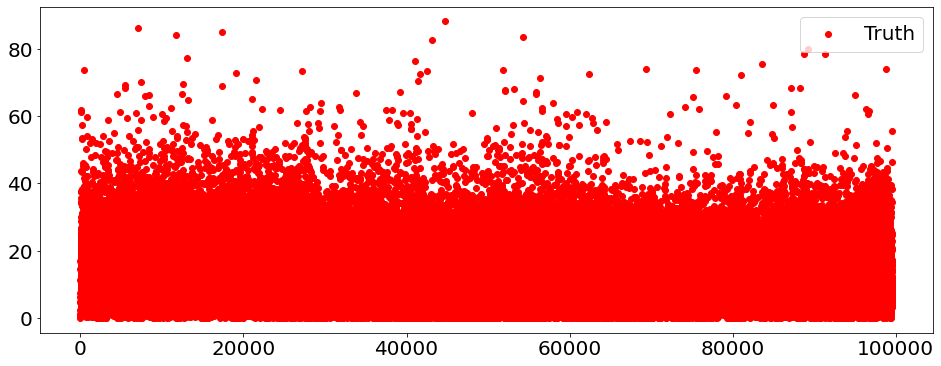

In [13]:
rcParams['figure.figsize'] = 16, 6
rcParams['font.size'] = 20
fig, ax = plt.subplots() 
ax.scatter(np.linspace(0,len(allTargets), len(allTargets)), allTargets, c="r", label = "Truth")
ax.legend()
plt.show()

In [14]:
dtf.head(3)

,VendorID,trip_distance,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,duration
0,1,1.2,0.0,0.3,11.27,2.5,4.800000
1,1,1.2,0.0,0.3,12.30,2.5,7.416667
2,1,0.6,0.0,0.3,10.80,2.5,6.183333


In [15]:
df_Y = dtf["duration"]
df_Y.head(3)

0    4.800000
1    7.416667
2    6.183333
Name: duration, dtype: float64

In [16]:
df_X=dtf.drop(columns=["duration"], inplace= False)
df_X.head(3)

,VendorID,trip_distance,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,1.2,0.0,0.3,11.27,2.5
1,1,1.2,0.0,0.3,12.30,2.5
2,1,0.6,0.0,0.3,10.80,2.5


In [17]:
X_test, X_train, y_test, y_train = train_test_split(df_X,
                                                    df_Y,
                                                    test_size=0.8,
                                                    random_state=7,
                                                    shuffle=True)

print("Checking train dimensions: ", len(X_train), len(y_train))
print("Checking test dimensions: ", len(X_test), len(y_test))
print("Checking ORIGINAL dimensions: ", len(df_X), len(df_Y))

Checking train dimensions:  79644 79644
Checking test dimensions:  19910 19910
Checking ORIGINAL dimensions:  99554 99554


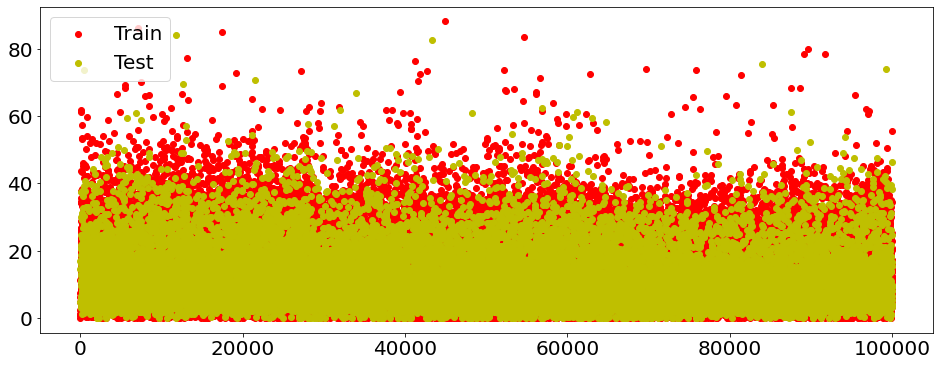

In [18]:
rcParams['figure.figsize'] = 16, 6
rcParams['font.size'] = 20
fig, ax = plt.subplots()
testData = y_test.values
trainData = y_train.values
ax.scatter(X_train.index.values, trainData, c="r", label="Train")
ax.scatter(X_test.index.values, testData, c="y", label="Test")
ax.legend()
plt.show()

# Fit the quantile regression


- The quantile regression model is called twice: upper and lower
- The normal L2 loss function is also called to prediction (as we'd normally do).
- The way I constructed the alphas is by giving the confidence level so to have the tails symmetrical distributed. **However**, you can also feed the alphas (percentile) directly.



In [19]:
confidenceLevel = 0.95
alphaUpper = confidenceLevel + (1 - confidenceLevel)/2
alphaLower= (1 - confidenceLevel)/2
print(alphaUpper*100, alphaLower*100)

97.5 2.500000000000002


In [20]:
# upper percentile
model = XGBRegressor(objective=log_cosh_quantile(alphaUpper),
                     n_estimators=125,
                     max_depth=5,
                     n_jobs=-1,
                     learning_rate=.05)
model.fit(X_train, y_train)
y_upper_smooth = model.predict(X_test)

# lower percentile
model = XGBRegressor(objective=log_cosh_quantile(alphaLower),
                     n_estimators=125,
                     max_depth=5,
                     n_jobs=-1,
                     learning_rate=.05)
model.fit(X_train, y_train)
y_lower_smooth = model.predict(X_test)

# prediction
model = XGBRegressor(
    n_estimators=125,
    max_depth=5,
    n_jobs=-1,
    learning_rate=.05)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

[15:08:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


<ipython-input-6-bcb36d6287f6>:7: RuntimeWarning: overflow encountered in square
  hess = 1 / np.cosh(err)**2
<ipython-input-6-bcb36d6287f6>:7: RuntimeWarning: overflow encountered in cosh
  hess = 1 / np.cosh(err)**2


[15:08:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:08:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# Post-processing

## Assessing how got is our non-optimised model

In [21]:
# Compute the R2 error
r2 = r2_score(y_test, y_pred)

# Compute mean_squared_error
mse = mean_squared_error(y_test, y_pred)

# Compute root mean squared error
rmse = np.sqrt(mse)

print("R2: %0.2f" % (r2))
print("MSE: %0.2f" % (mse))
print("RMSE: %0.2f" % (rmse))

R2: 0.85
MSE: 11.61
RMSE: 3.41


In [22]:
inOrOut = []
width = []
for i, value in enumerate(y_test):
    width.append(y_upper_smooth[i] - y_lower_smooth[i])
    if y_lower_smooth[i] < value and value < y_upper_smooth[i]:
        inOrOut.append(True)
    else:
        inOrOut.append(False)

res = pd.DataFrame({'lower': y_lower_smooth,
                    'true': y_test,
                    "pred": y_pred,
                    'upper': y_upper_smooth,
                    "inOrOut": inOrOut,
                    "width": width})
res.head(3)

,lower,true,pred,upper,inOrOut,width
50592,4.408464,23.483333,22.245050,56.334156,True,51.925690
80804,3.627609,19.966667,17.763226,75.216415,True,71.588806
1120,2.587713,11.233333,12.952592,33.322826,True,30.735113


## PI coverage probability (PICP) & MPIW (Mean PI width)


- [More important] **PI coverage probability (PICP)** is measured by counting the number of target values covered by the constructed PIs, where where ntest is the number of samples in the test set 
- [Less important] PICP has a direct relationship with the width of PIs. A satisfactorily large PICP can be easily achieved by widening PIs from either side. However, such PIs are too conservative and less useful in practice, as they do not show the variation of the targets. Therefore, a measure is required to check how wide the PIs are. **Mean PI width (MPIW)** quantifies this aspect. 



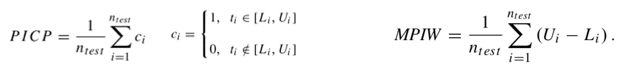

In [23]:
print("PICP: ", len(res[res['inOrOut'] == True])/len(X_test) * 100)
print("MPIW: ", np.sum(res['width'].values) / len(X_test) )

PICP:  86.57458563535911
MPIW:  33.3482376957766


## Plot the prediction interval

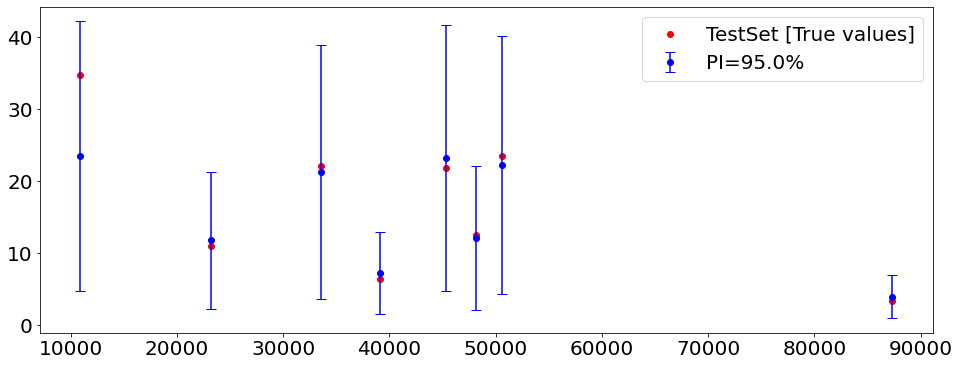

In [24]:
rcParams['figure.figsize'] = 16, 6
rcParams['font.size'] = 20
fig, ax = plt.subplots()

# We have to many value closesly spaced. We'll print them every 100 to help the visualisation.
skipRow = 2500

# The minus sign is added automatically by the error bar. That is why we use the abs()
deltaLOWER = abs(res["pred"] - res["lower"])
deltaUPPER = abs(res["pred"] - res["upper"])

ax.errorbar(res["pred"].index.values[::skipRow], res["pred"].values[::skipRow],
            yerr=np.array(deltaLOWER[::skipRow], deltaUPPER[::skipRow]).T,
            fmt='bo',
            solid_capstyle='projecting',
            capsize=5, label="PI=" + str(confidenceLevel*100)+"%")


ax.scatter(X_test.index.values[::skipRow],
           testData[::skipRow], c="r", label="TestSet [True values]")


ax.legend()
plt.show()

# References


- https://towardsdatascience.com/confidence-intervals-for-xgboost-cac2955a8fde<br>
- https://gist.github.com/kayhman/d5f7ff0bf1b0ba293340c942a316844a<br>
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4054530/<br>



# Conclusion


- Quantile regression is nothing more than a MAE loss function but scaled and rotated.
- There are 2 version of the quantile loss: smooth and sharp. You are free to use the one you like.
- Remember gradient boosting needs a loss function that is C1 and **C2**.
- You need to run two additional fits to get the prediction interval.
- Prediction and confidence intervals are **not** the same thing.

